In [1]:
import numpy as np
import pandas as pd
import pickle
import torch
import random
import csv

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import seaborn as sns
from sklearn import metrics
import squarify

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from weights_parser import WeightsParser

from models import LogisticRegressionWithSummaries_Wrapper, LogisticRegressionWithSummariesAndBottleneck_Wrapper, LSTM_Baseline

from custom_losses import custom_bce_horseshoe

from preprocess_helpers import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import binary_cross_entropy_with_logits

from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from itertools import combinations

from tqdm import tqdm
from time import sleep

## Load patient data & vasopressor target

In [2]:
X_np, Y_logits, changing_vars, data_cols = preprocess_MIMIC_data('data/X_vasopressor_LOS_6_600.p', 'data/y_vasopressor_LOS_6_600.p')
# X_np, Y_logits, changing_vars, data_cols = preprocess_MIMIC_data('data/X_death_early_vasopressor.p', 'data/y_death_early_vasopressor.p')
input_dim = X_np[0].shape[1]
changing_dim = len(changing_vars)

In [3]:
changing_dim

28

## Helper functions for model learning

In [4]:
# init thresholds C to 12

def init_cutoffs_to_twelve(d):
    return np.zeros(d) + 12

def init_cutoffs_to_zero(d):
    return np.zeros(d)

def init_cutoffs_to_twentyfour(d):
    return np.zeros(d) + 24

In [5]:
# Initialize all cutoffs to x
def init_cutoffs_to_x(d, x):
    return np.zeros(d) + x

# Initialize all cutoffs to a uniform random integer between 0 and (x - 1)
def init_cutoffs_randomly(d):
    return np.random.randint(6, size=d).astype('float')

In [6]:
# init the upper and lower thresholds to random values

def init_rand_upper_thresholds(d):
    return np.random.rand(d)

def init_rand_lower_thresholds(d):
    return np.random.rand(d) - 1

def init_zeros(d):
    return np.zeros(d)

In [7]:
def tensor_wrap(x, klass=torch.Tensor):
    return x if 'torch' in str(type(x)) else klass(x)

def initializeData(r):   
    
    # train-test-split
    torch.set_printoptions(sci_mode=False)
    X_train, X_test, y_train, y_test = train_test_split(X_np, Y_logits, test_size = 0.15, random_state = r, stratify = Y_logits)

    # train-val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.20, random_state = r, stratify = y_train)

    X_pt = Variable(tensor_wrap(X_np)).cuda()
    
#     print("y_test information")
#     print(sum(np.array(y_test)[:, 1]==1))
#     print([i for i, x in enumerate(np.array(y_test)[:, 1]) if x==1])
    
    # initiazing datasets
    pos_prop = np.mean(np.array(Y_logits)[:, 1])

    p_weight = torch.Tensor([1 / (1 - pos_prop), 1 / pos_prop]).cuda()

    X_train_pt = Variable(tensor_wrap(X_train)).cuda()
    y_train_pt = Variable(tensor_wrap(y_train, torch.FloatTensor)).cuda()

    X_val_pt = Variable(tensor_wrap(X_val)).cuda()
    y_val_pt = Variable(tensor_wrap(y_val, torch.FloatTensor)).cuda()

    X_test_pt = Variable(tensor_wrap(X_test)).cuda()
    y_test_pt = Variable(tensor_wrap(y_test, torch.FloatTensor)).cuda()

    batch_size = 128

    train_dataset = TensorDataset(X_train_pt, y_train_pt)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    val_dataset = TensorDataset(X_val_pt, y_val_pt)
    val_loader = DataLoader(val_dataset, batch_size = X_val_pt.shape[0], shuffle=True, num_workers=0)

    test_dataset = TensorDataset(X_test_pt, y_test_pt)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    return train_loader, val_loader, X_test, y_test, p_weight

In [8]:
def initializeModel(c):
#     vals_to_init = init_cutoffs_randomly(changing_dim * 9)
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,                     
                                                c,
                                                True,
                                                init_cutoffs_to_zero, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=None)
    logregbottleneck.cuda()
    return logregbottleneck

def initializeModelNoBottleneck():
    vals_to_init = init_cutoffs_randomly(changing_dim * 9)
    logreg = LogisticRegressionWithSummaries_Wrapper(input_dim, 
                                                changing_dim, 
                                                9,        
                                                True,
                                                init_cutoffs_randomly, 
                                                init_rand_lower_thresholds, 
                                                init_rand_upper_thresholds,
                                                cutoff_times_temperature=0.1,
                                                cutoff_times_init_values=vals_to_init)
    logreg.cuda()
    return logreg

def getAUC(model, X_test, y_test):
    # get results of forward, do AUROC
    y_hat_test = []
    for pat in X_test:
        # batch size of 1
        x = tensor_wrap([pat]).cuda()
        y_hat_test.append(model.sigmoid(model.forward(x))[:,1].item())
    score = roc_auc_score(np.array(y_test)[:, 1], y_hat_test)
    
    return score

def getWeights(model):
    weights=logregbottleneck.model.bottleneck.weight.cpu().detach().numpy()
    return np.mean(np.absolute(weights), axis=1), weights

In [9]:
def set_seed(r):
    torch.backends.cudnn.deterministic = True
    random.seed(r)
    torch.manual_seed(r)
    torch.cuda.manual_seed(r)
    np.random.seed(r)

In [10]:
summary_dict = {0:'mean', 1:'var', 2:'ever measured', 3:'mean of indicators', 4: 'var of indicators', 5:'# switches', 6:'slope', 7:'slope std err', 8:'first time measured', 9:'last time measured', 10:'hours above threshold', 11:'hours below threshold'}
def getConcept(c):
    if c < 66:
        # raw feature
        return data_cols[c],'N/A'
    else:
        # summary statistic of feature
        c = c-66
        summary = c//28
        feature = c % 28
        return data_cols[feature], summary_dict[summary]

# Investigate Bottleneck Models (no reg)

In [ ]:
train_loader, val_loader, X_test, y_test, p_weight = initializeData(1)
set_seed(1)
logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                            changing_dim,
                                                                            9,                     
                                                                            1,
                                                                            True,
                                                                            init_cutoffs_to_zero, 
                                                                            init_rand_lower_thresholds, 
                                                                            init_rand_upper_thresholds,
                                                                            cutoff_times_temperature=1.0,
                                                                            cutoff_times_init_values=None,
                                                                            opt_lr = 0.1,
                                                                            opt_weight_decay = 0)
#                                                                            l1_lambda=1e-04)
logregbottleneck.cuda()
set_seed(1)
logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/no-reg/test.pt", 
                     epochs=10, 
                     save_every_n_epochs=10)

In [ ]:
getAUC(logregbottleneck.model,X_test,y_test)

## Plot num concepts vs. AUC for fixed hyperparam combo

In [10]:
# BASELINE: get AUCs from hyperparameter scan
baseline_aucs_all = []
baseline_hyperparams_all = []
baseline_top1_all = []
baseline_top1_aucs_all = []
for r in range(1,4):
    file = open('./models/LOS-6-600/baseline/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
        baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    baseline_hyperparams_all = baseline_rows[:,:4]
    baseline_aucs_all =  baseline_rows[:,4]
    
    # top 1
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top1=sorted_baseline_rows[-1:]
    baseline_top1_auc=sorted_baseline_rows[-1:][:,4]
    baseline_top1_all.append(baseline_top1)
    baseline_top1_aucs_all.append(baseline_top1_auc)

In [ ]:
np.mean(baseline_top1_aucs_all)

In [11]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_aucs_all = []
bottleneck_hyperparams_all = []
bottleneck_top1_all = []
bottleneck_top1_aucs_all = []
for r in range(1,4):
    bottleneck_aucs_run = []
    bottleneck_hyperparams_run = []
    bottleneck_top1_run = []
    bottleneck_top1_aucs_run = []
    for c in range(1,16):
        file = open('./models/LOS-6-600/no-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        
        # top 1
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,3])]
        bottleneck_top1=(sorted_bottleneck_rows[-1:])
        bottleneck_top1_aucs=(sorted_bottleneck_rows[-1:][:,3])
        
        # sort by hyperparamts
        bottleneck_rows = bottleneck_rows[np.lexsort((bottleneck_rows[:,2], bottleneck_rows[:,1]))]
        aucs = np.array([bottleneck_rows[:,3]]).T
        if c==1:
            bottleneck_aucs_run = aucs
            bottleneck_hyperparams_run=bottleneck_rows[:,:3]
        else:
            bottleneck_aucs_run=np.concatenate((bottleneck_aucs_run,aucs),axis=1)
        bottleneck_top1_run.append(bottleneck_top1)
        bottleneck_top1_aucs_run.append(bottleneck_top1_aucs)
    bottleneck_aucs_all.append(bottleneck_aucs_run)
    bottleneck_hyperparams_all.append(bottleneck_hyperparams_run)
    bottleneck_top1_all.append(bottleneck_top1_run)
    bottleneck_top1_aucs_all.append(bottleneck_top1_aucs_run)

In [17]:
# LSTM: get AUCs from hyperparameter scan
# lstm_aucs_all = []
lstm_top1_all = []
lstm_top1_aucs_all = []
rs = [1,6]
for r in rs:
    file = open('./models/LOS-6-600/lstm/vasopressor_lstm_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    lstm_rows = []
    for row in csvreader:
        lstm_rows.append(np.array(row).astype(float))
    lstm_rows = np.array(lstm_rows)
    lstm_hyperparams_all = lstm_rows[:,:7]
    lstm_aucs_all =  lstm_rows[:,7]
    
    # top 1
    sorted_lstm_rows = lstm_rows[np.argsort(lstm_rows[:,7])]
    lstm_top1=sorted_lstm_rows[-1:]
    lstm_top1_auc=sorted_lstm_rows[-1:][:,7]
    lstm_top1_all.append(lstm_top1)
    lstm_top1_aucs_all.append(lstm_top1_auc)

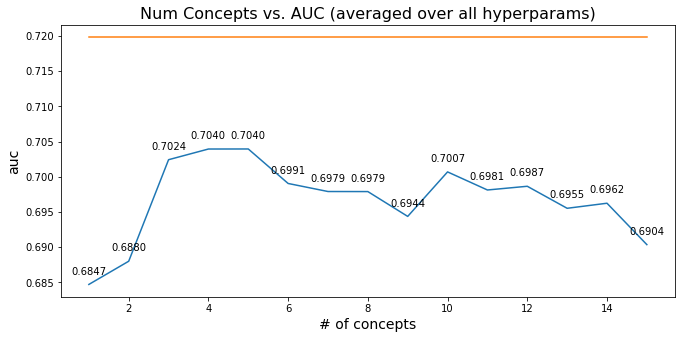

In [13]:
# Plot num concepts vs. AUC when averaged across all hyperparams
xs = np.arange(1,16)
ys = np.mean(np.mean(bottleneck_aucs_all,axis=0),axis=0)
plt.figure(figsize=(11,5))
plt.plot(xs,ys)
for x,y in zip(xs,ys):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.plot(xs,np.repeat(np.mean(baseline_aucs_all),15))
plt.title("Num Concepts vs. AUC (averaged over all hyperparams)",fontsize=16)
plt.xlabel("# of concepts",fontsize=14)
plt.ylabel("auc",fontsize=14)
plt.show()

In [ ]:
np.mean(bottleneck_aucs_all,axis=0)[0]

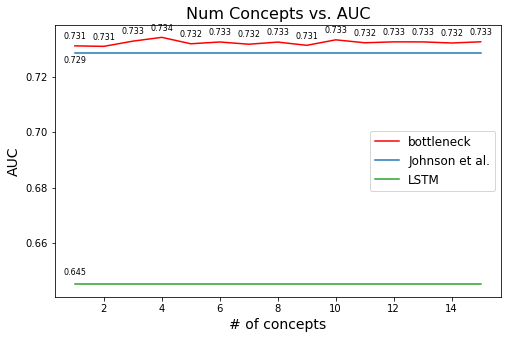

In [55]:
# plot num concepts vs AUC for top 1 hyperparam
xs = np.arange(1,16)
ys = np.mean(bottleneck_top1_aucs_all,axis=0).T[0]
plt.figure(figsize=(8,5))
plt.plot(xs,ys,label = "bottleneck",color="red")
for x,y in zip(xs,ys):

    label = "{:.3f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,7), # distance from text to points (x,y)
                 ha='center',
                fontsize=8) # horizontal alignment can be left, right or center
plt.plot(xs,np.repeat(np.mean(baseline_top1_aucs_all),15),label="Johnson et al.", color="tab:blue")
plt.plot(xs,np.repeat(np.mean(lstm_top1_aucs_all),15),label="LSTM", color="tab:green")
plt.annotate("{:.3f}".format(np.mean(baseline_top1_aucs_all)), # this is the text
             (1,np.mean(baseline_top1_aucs_all)), # these are the coordinates to position the label
             textcoords="offset points", # how to position the text
             xytext=(0,-10), # distance from text to points (x,y)
             ha='center',
            fontsize=8) # horizontal alignment can be left, right or center
plt.annotate("{:.3f}".format(np.mean(lstm_top1_aucs_all)), # this is the text
             (1,np.mean(lstm_top1_aucs_all)), # these are the coordinates to position the label
             textcoords="offset points", # how to position the text
             xytext=(0,10), # distance from text to points (x,y)
             ha='center',
            fontsize=8) # horizontal alignment can be left, right or center
plt.title("Num Concepts vs. AUC",fontsize = 16)
plt.xlabel("# of concepts",fontsize=14)
plt.ylabel("AUC",fontsize=14)
plt.legend(fontsize=12)
plt.show()

# Investigate Bottleneck Models (l1 reg)

In [11]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_reg_all = []
bottleneck_aucs_reg_all = []
for r in range(1,4):
    bottleneck_reg_run = []
    bottleneck_aucs_reg_run = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,3])]
        bottleneck_reg_run.append(sorted_bottleneck_rows[1:])
        bottleneck_aucs_reg_run.append(sorted_bottleneck_rows[1:,4])
    bottleneck_reg_all.append(bottleneck_reg_run)
    bottleneck_aucs_reg_all.append(bottleneck_aucs_reg_run)

## Select Optimal # of Concepts

In [12]:
raw_sum_by_concept = []
for r in range(1,4):
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    raw_sum_by_concept_run = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(row)
        raw_sum = []
        for row in bottleneck_reg_all[r-1][c-1]:
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]
            
            # initialize model
            logregbottleneck = initializeModel(c)
            
            logregbottleneck.fit(train_loader, val_loader, p_weight, 
                 save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3]), 
                 epochs=1000, 
                 save_every_n_epochs=10)

            for name, param in logregbottleneck.named_parameters():
                if "bottleneck.weight" in name:
                    bottleneck_weights = param
            raw_sum.append(torch.norm(bottleneck_weights,dim=1).cpu().detach().numpy())
        raw_sum_by_concept_run.append(raw_sum)
    raw_sum_by_concept.append(raw_sum_by_concept_run)

self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c1_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c2_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c3_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.0001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.0001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.0001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.0001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.0001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.0001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c5_optlr_0.0001_optwd_0.0001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c6_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c7_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r2_c8_optlr_0.001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c1_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c2_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c3_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c5_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c6_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c7_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.001_l1_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.001_l1_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.001_l1_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.001_l1_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r3_c8_optlr_0.0001_optwd_0.001_l1_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


In [13]:
indices = []
for i in np.mean(raw_sum_by_concept,axis=0):
    for ind, num in enumerate(i):
        if (np.all(num<1.2)):
            indices.append(ind)
            break

/n/home07/carissawu/.conda/envs/nj/lib/python3.8/site-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


In [14]:
indices

[3, 3, 3, 2, 2, 2, 2, 2]

In [15]:
# BOTTLENECK: get AUCs from hyperparameter scan

indices = []
for i in np.mean(raw_sum_by_concept,axis=0):
    for ind, num in enumerate(i):
        if (np.all(num<1.2)):
            indices.append(ind)
            break
            
bottleneck_reg_fix = []
bottleneck_auvcs_reg_fix = []
for c in range(1,9):
    bottleneck_aucs_reg_fix.append(np.mean(bottleneck_aucs_reg_all,axis=0)[c-1][indices[c-1]])

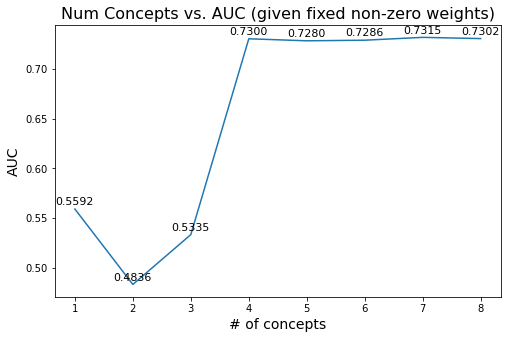

In [17]:
xs = np.arange(1,9)
ys = bottleneck_aucs_reg_fix
plt.figure(figsize=(8,5))
plt.plot(xs,ys)
for x,y in zip(xs,ys):

    label = "{:.4f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,4), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center,
                fontsize=11)
plt.title("Num Concepts vs. AUC (given fixed non-zero weights)", fontsize=16)
plt.xlabel("# of concepts", fontsize=14)
plt.ylabel("AUC", fontsize=14)
plt.show()

## 0-weight concept experiment

In [62]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_0weight_all = []
bottleneck_aucs_0weight_all = []
for r in range(1,3):
    bottleneck_0weight_run = []
    bottleneck_aucs_0weight_run = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/zero-weight/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,3])]
        bottleneck_0weight_run.append(sorted_bottleneck_rows[1:])
        bottleneck_aucs_0weight_run.append(sorted_bottleneck_rows[1:,4])
    bottleneck_0weight_all.append(bottleneck_0weight_run)
    bottleneck_aucs_0weight_all.append(bottleneck_aucs_0weight_run)

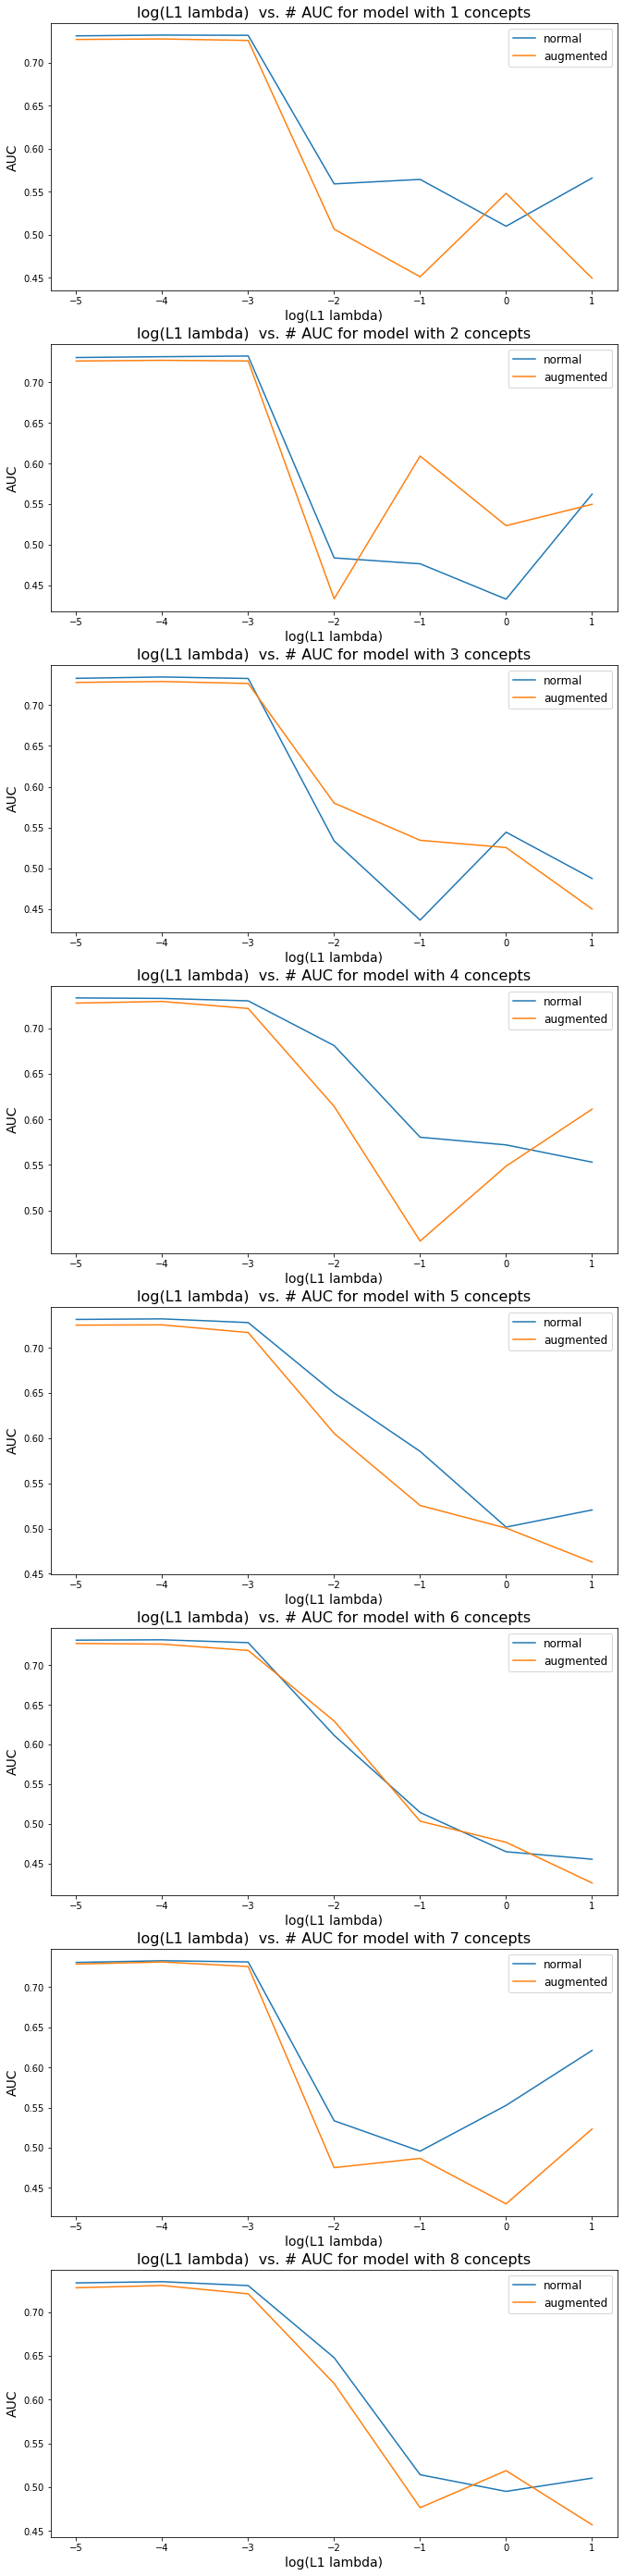

In [75]:
fig, axs = plt.subplots(8, 1,figsize=(11,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
# colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for c in range(1,9):
    axs[c-1].plot(np.log10(arr_l1_lambda),np.mean(bottleneck_aucs_reg_all,axis=0)[c-1],label = "normal")
    axs[c-1].plot(np.log10(arr_l1_lambda),np.mean(bottleneck_aucs_0weight_all,axis=0)[c-1], label = "augmented")
#     axs[c-1].plot(np.arange(-5,2), np.repeat(baseline_top1_auc[0],7), '-r', label='baseline auc')
    axs[c-1].set_xlabel("log(L1 lambda)",fontsize=14)
    axs[c-1].set_ylabel("AUC", fontsize=14)
    axs[c-1].set_title("log(L1 lambda)  vs. # AUC for model with " + str(c)+" concepts", fontsize=16)
    axs[c-1].legend(fontsize=12)

# Cos-sim regularized models

In [10]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_reg_all = []
bottleneck_aucs_reg_all = []
for r in range(1,4):
    bottleneck_reg_run = []
    bottleneck_aucs_reg_run = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,4])]
        bottleneck_reg_run.append(sorted_bottleneck_rows[1:])
        bottleneck_aucs_reg_run.append(sorted_bottleneck_rows[1:,5])
    bottleneck_reg_all.append(bottleneck_reg_run)
    bottleneck_aucs_reg_all.append(bottleneck_aucs_reg_run)

In [11]:
feature_weights = []
concept_weights = []
for r in range(1,2):
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    feature_weights_run = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(row)
        feature_weights_concept = []
        for row in bottleneck_reg_all[r-1][c-1]:
            # format hyperparameters for csv reader
            row=[int(el) if el >= 1 else el for el in row]
            row=[0 if el == 0 else el for el in row]
            
            # initialize model
            logregbottleneck = initializeModel(c)
            
            logregbottleneck.fit(train_loader, val_loader, p_weight, 
                 save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]), 
                 epochs=1000, 
                 save_every_n_epochs=10)

            for name, param in logregbottleneck.named_parameters():
                if "bottleneck.weight" in name:
                    bottleneck_weights = param
            feature_weights_concept.append(bottleneck_weights.cpu().detach().numpy())
        feature_weights_run.append(feature_weights_concept)
    feature_weights.append(feature_weights_run)

self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01_cossim_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_1e-05.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.0001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_1.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_10.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


In [ ]:
feature_weights[0][1][1].shape

## Plot lambda vs. AUC by concept

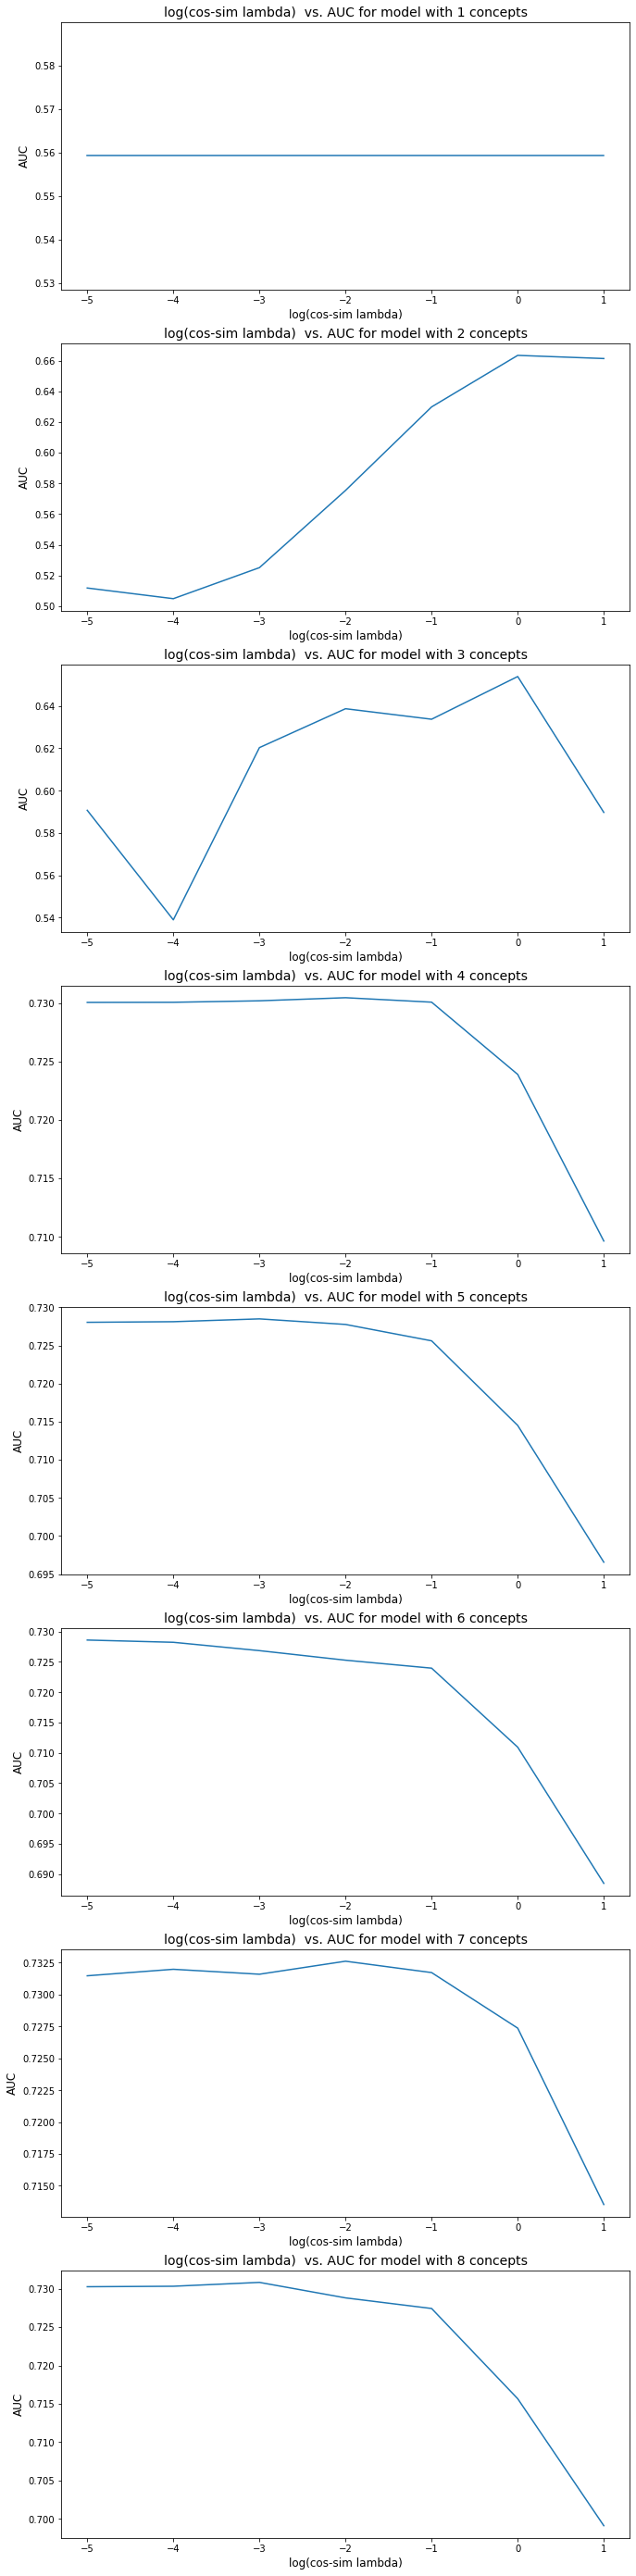

In [30]:
fig, axs = plt.subplots(8, 1,figsize=(11,50))
# fig.suptitle('Across 3 train/test splits')

arr_l1_lambda = [1e-5,1e-4,1e-3,1e-2,1e-1,1,10]
# colors = ['black','grey','brown','magenta','orange','yellow','green','aqua','blue','purple']
for c in range(1,9):
    axs[c-1].plot(np.log10(arr_l1_lambda),np.mean(bottleneck_aucs_reg_all,axis=0)[c-1])
#     axs[c-1].plot(np.arange(-5,2), np.repeat(baseline_top1_auc[0],7), '-r', label='baseline auc')
    axs[c-1].set_xlabel("log(cos-sim lambda)",fontsize =12)
    axs[c-1].set_ylabel("AUC",fontsize =12)
    axs[c-1].set_title("log(cos-sim lambda)  vs. AUC for model with " + str(c)+" concepts",fontsize =14)

# Improving Concept Distinction Experiments

## Switch concepts before prediction

In [ ]:
# BOTTLENECK: get AUCs from hyperparameter scan

c1 = 2
c2 = 3
for r in range(1,4):
    bottleneck_reg_run = []
    bottleneck_aucs_reg_run = []
    c = 4
    file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
    csvreader = csv.reader(file)
    header = next(csvreader)
    bottleneck_row = []
    for row in csvreader:
#         if row[3]=="0.001" and row[4]=="0.01":
        if row[3]=="0.001":
            bottleneck_row = np.array(row).astype(float)
            
    # format hyperparameters for csv reader
    row=[int(el) if el >= 1 else el for el in bottleneck_row]
    row=[0 if el == 0 else el for el in bottleneck_row]
    
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    set_seed(r)
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                                changing_dim,
                                                                                9,                     
                                                                                4,
                                                                                True,
                                                                                init_cutoffs_to_zero, 
                                                                                init_rand_lower_thresholds, 
                                                                                init_rand_upper_thresholds,
                                                                                cutoff_times_temperature=1.0,
                                                                                cutoff_times_init_values=None,
                                                                                opt_lr = 0.0001,
                                                                                opt_weight_decay = 0,
                                                                                l1_lambda=0.001,
                                                                                )
    logregbottleneck.cuda()
    set_seed(r)
    logregbottleneck.fit(train_loader, val_loader, p_weight, 
#                          save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r,int(row[0]),row[1],row[2],row[3],row[4]), 
                         save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}.pt".format(r,int(row[0]),row[1],row[2],row[3]), 
                         epochs=10, 
                         save_every_n_epochs=10)
    
    # get AUC before
    print("AUC before")
    print(getAUC(logregbottleneck.model,X_test,y_test))
    
    # switch concepts
    temp = logregbottleneck.model.linear.weight[:,c2].clone().detach()
    logregbottleneck.model.linear.weight[:,c2] = logregbottleneck.model.linear.weight[:,c1]
    logregbottleneck.model.linear.weight[:,c1] = temp
    
    # get AUC after
    print("AUC after")
    print(getAUC(logregbottleneck.model,X_test,y_test))

# Top K features

## Get top features

In [22]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_reg_all = []
bottleneck_aucs_reg_all = []
for r in range(1,4):
    bottleneck_reg_run = []
    bottleneck_aucs_reg_run = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,4])]
        bottleneck_reg_run.append(sorted_bottleneck_rows[1:])
        bottleneck_aucs_reg_run.append(sorted_bottleneck_rows[1:,5])
    bottleneck_reg_all.append(bottleneck_reg_run)
    bottleneck_aucs_reg_all.append(bottleneck_aucs_reg_run)

In [74]:
feature_weights = []
concept_weights = []
for r in range(1,11):
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    feature_weights_run = []
    for c in range(4,5):
        file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
#         for row in bottleneck_reg_all[r-1][c-1]:
        for row in bottleneck_rows:
            print(row)
            if row[3]==0.001 and row[4]==0.01:
                # format hyperparameters for csv reader
                row=[int(el) if el >= 1 else el for el in row]
                row=[0 if el == 0 else el for el in row]

                # initialize model
                logregbottleneck = initializeModel(c)
#                 print("./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]))
                logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]), 
                     epochs=1000, 
                     save_every_n_epochs=10)

                for name, param in logregbottleneck.named_parameters():
                    if "bottleneck.weight" in name:
                        bottleneck_weights = param
                feature_weights_run.append(bottleneck_weights.cpu().detach().numpy())
    feature_weights.append(feature_weights_run)

[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e+01 6.84248759e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 0.00000000e+00 7.22502989e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e+00 7.10384255e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-01 7.25255077e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-03 7.23613371e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-02 7.24628281e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-04 7.22596385e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-05 7.22509215e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e+01 7.20787604e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e+00 7.21503645e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 0.00000000e+00 7.22792518e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-01 7.22234214e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 7.22846481e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.22547612e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-05 7.22873462e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-04 7.22848556e-01]
[4.0000000e+00 1.0000000e-04 1.0000000e-03 1.0000000e-03 1.0000000e+01
 7.2388007e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e+00 7.39825992e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 0.00000000e+00 7.44842429e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-01 7.42779401e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.44238464e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-03 7.44157521e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-04 7.44792618e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-05 7.44825826e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-02 7.39402594e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r4_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-02 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.16543245e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r5_c4_optlr_0.01_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.07934149e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r6_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-02 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.42804307e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r7_c4_optlr_0.01_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-02 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.07164146e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r8_c4_optlr_0.01_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.0000000e+00 1.0000000e-04 1.0000000e-03 1.0000000e-03 1.0000000e-02
 7.0215601e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r9_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.28186694e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r10_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


r
10


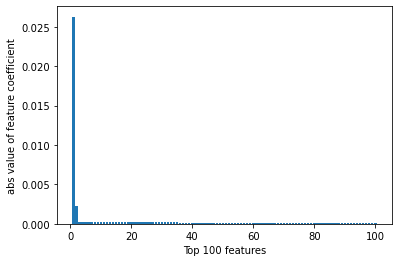

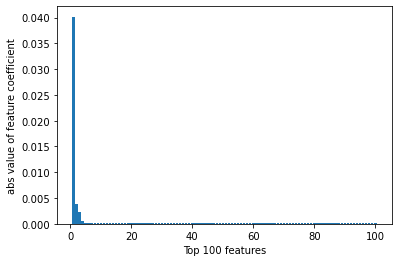

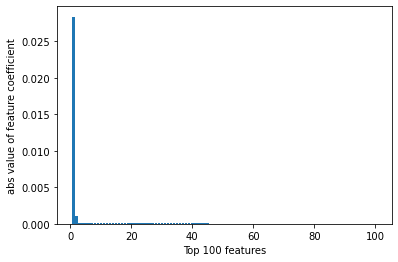

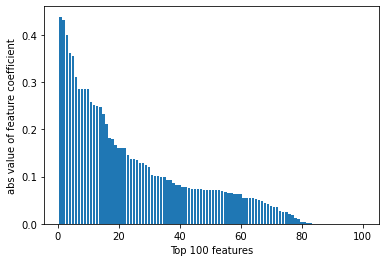

In [75]:
# PRE OPTIMIZATION
rs=[10]
for r in rs:
    print("r")
    print(r)
    for c in range(4):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        inds = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))[:100]
        ax.bar(np.arange(1,101),np.abs(feature_weights[r-1][0][c])[inds])
        ax.set_xlabel("Top 100 features")
        ax.set_ylabel("abs value of feature coefficient")
        plt.show()

## Save Top K inds to csv file

In [76]:
bottleneck_topk_all = []
bottleneck_aucs_topk_all = []
rs = [10]
for r in rs:
    bottleneck_topk_run = []
    bottleneck_aucs_topk_run = []
    for c in range(4,5):
        file = open('./models/LOS-6-600/cos-sim/top-k/vasopressor_bottleneck_r{}_c{}_topkinds.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        bottleneck_topk_run.append(bottleneck_rows)
        bottleneck_aucs_topk_run.append(bottleneck_rows[:,0])
    bottleneck_topk_all.append(bottleneck_topk_run)
    bottleneck_aucs_topk_all.append(bottleneck_aucs_topk_run)

## Plots for Top-k inds

In [79]:
best_feat_weights = []
best_feat_concs = []
    
for r in range(len(rs)):
    names = []
    funcs = []
    weights = []
    c=4
    bottleneck_top10_all = np.array(bottleneck_topk_all)[r][0][:14]
    bottleneck_top10_all_sorted=np.array(bottleneck_top10_all)[np.array(bottleneck_top10_all)[:, 1].argsort()]
    for el in bottleneck_top10_all_sorted:
        name,func = getConcept(int(el[2]))
        weight = feature_weights_bottleneck[r][int(el[1])][int(el[2])]
        best_feat_weights.append(weight)
        best_feat_concs.append(int(el[1]))

In [80]:
best_feat_concs

[0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3]

In [81]:
best_feat_inds = []
best_feat_per_conc_x = [[],[],[],[]]
best_feat_per_conc_y = [[],[],[],[]]
for i in range(14):
    inds = np.argsort(-np.abs(np.array(feature_weights_bottleneck)[r-1][best_feat_concs[i]]))[:100]
    top100 = feature_weights_bottleneck[r-1][best_feat_concs[i]][inds]
    ind = np.where(top100==best_feat_weights[i])[0]
    if np.array_equal(ind,np.array([])):
        ind = np.array([100])
    best_feat_inds.append(ind[0])
    best_feat_per_conc_x[best_feat_concs[i]].append(ind[0])
    best_feat_per_conc_y[best_feat_concs[i]].append(best_feat_weights[i])
best_feat_inds
print(best_feat_per_conc_x)
best_feat_per_conc_y

[[47, 0, 11], [3, 100], [0], [44, 50, 8, 11, 49, 26, 30, 46]]


[[0.00015103967, 0.026280269, -0.00020109689],
 [-0.0004808791, 6.687577e-05],
 [-0.028344799],
 [-0.07442154,
  0.0708194,
  -0.28571767,
  0.25208187,
  0.0715895,
  -0.12836534,
  0.10278183,
  0.073938005]]

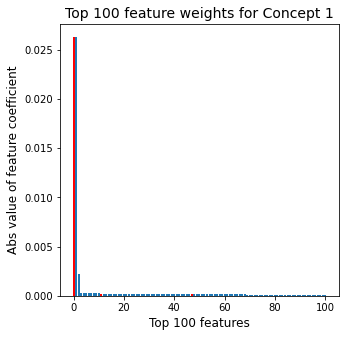

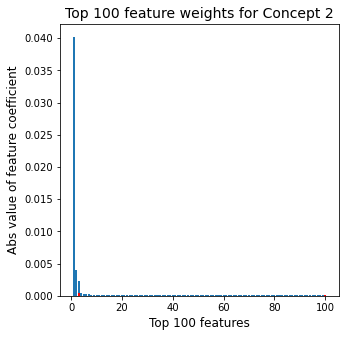

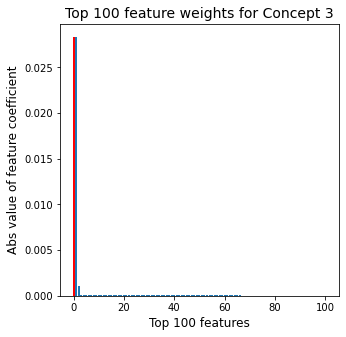

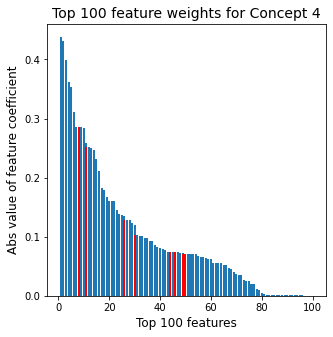

In [96]:
# POST OPTIMIZATION
best_inds = bottleneck_topk_all[:14][0][0]
best_inds_x = bottleneck_topk_all[:14][0][0][:,0]
rs=[10]
for r in rs:
    for c in range(4):
        fig = plt.figure(figsize=[5,5])
        ax = fig.add_subplot(111)
        inds = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))[:100]
        ax.bar(np.arange(1,101),np.abs(feature_weights[r-1][0][c])[inds])
        ax.bar(best_feat_per_conc_x[c],np.abs(best_feat_per_conc_y[c]),color='r')
        ax.set_xlabel("Top 100 features",fontsize=12)
        ax.set_title("Top 100 feature weights for Concept "+str(c+1),fontsize=14)
        ax.set_ylabel("Abs value of feature coefficient",fontsize=12)
        plt.show()

## Save Top 90th Percentile of inds for greedy method

In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(np.array(feature_weights)),axis=3)*0.90
sum90p.shape

In [ ]:
topkinds = []
for r in range(1,11):
    topkinds_run = []
    for c in range(4):
        topkinds_conc = []
        curr_sum = 0
        inds = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))
        sorted_weights = np.array(feature_weights)[r-1][0][c][inds]
        for ind,weight in zip(inds,sorted_weights):
            curr_sum += abs(weight)
            if curr_sum <= sum90p[r-1][0][c]:
                topkinds_conc.append(ind)
            else:
                break
        if len(topkinds_conc)<10:
            topkinds_conc = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))[:10].tolist()
        topkinds_run.append(topkinds_conc)
    topkinds.append(topkinds_run)

In [ ]:
# write top k inds to csv
for r in range(1,11):
    filename = "./models/LOS-6-600/cos-sim/top-k/topkindsr{}c4.csv".format(r)

    # writing to csv file 
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)
        # writing the data rows 
        csvwriter.writerows(topkinds[r-1])

## 8 Concept Greedy experiment

In [ ]:
feature_weights = []
concept_weights = []
for r in range(1,4):
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    feature_weights_run = []
    for c in range(8,9):
        file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        for row in bottleneck_rows:
            print(row)
            if row[3]==0.001 and row[4]==0.01:
                # format hyperparameters for csv reader
                row=[int(el) if el >= 1 else el for el in row]
                row=[0 if el == 0 else el for el in row]

                # initialize model
                logregbottleneck = initializeModel(c)
                logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]), 
                     epochs=1000, 
                     save_every_n_epochs=10)

                for name, param in logregbottleneck.named_parameters():
                    if "bottleneck.weight" in name:
                        bottleneck_weights = param
                feature_weights_run.append(bottleneck_weights.cpu().detach().numpy())
    feature_weights.append(feature_weights_run)

In [ ]:
# get 90th percentile of feature weights
sum90p = np.sum(np.abs(np.array(feature_weights)),axis=3)*0.90
sum90p.shape

In [ ]:
topkinds = []
for r in range(1,4):
    topkinds_run = []
    for c in range(8):
        topkinds_conc = []
        curr_sum = 0
        inds = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))
        sorted_weights = np.array(feature_weights)[r-1][0][c][inds]
        for ind,weight in zip(inds,sorted_weights):
            curr_sum += abs(weight)
            if curr_sum <= sum90p[r-1][0][c]:
                topkinds_conc.append(ind)
            else:
                break
        if len(topkinds_conc)<10:
            topkinds_conc = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))[:10].tolist()
        topkinds_run.append(topkinds_conc)
    topkinds.append(topkinds_run)

In [ ]:
# write top k inds to csv
for r in range(1,4):
    filename = "./models/LOS-6-600/cos-sim/top-k/topkindsr{}c8.csv".format(r)

    # writing to csv file 
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)
        # writing the data rows 
        csvwriter.writerows(topkinds[r-1])

# Compare Greedy with Nari Baseline 

In [10]:
baseline_top1_all = []
for r in range(1,11):
    set_seed(r)
    file = open('./models/LOS-6-600/baseline/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
        baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top1=sorted_baseline_rows[-1:]
    baseline_top1_auc=sorted_baseline_rows[-1:][:,4]
    baseline_top1_all.append(baseline_top1)

In [31]:
baseline_top1_all[0][0]

array([1.00000000e-02, 1.00000000e+00, 1.00000000e-04, 1.00000000e-04,
       7.32105202e-01])

In [11]:
feature_weights = []
# for r in rs:
for r in range(1,11):
    row = baseline_top1_all[r-1][0]
    row=[int(el) if el >= 1 else el for el in row]
    row=[0 if el == 0 else el for el in row]
    logreg = initializeModelNoBottleneck()
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)

    logreg = LogisticRegressionWithSummaries_Wrapper(input_dim, 
                                                    changing_dim, 
                                                    9,        
                                                    True,
                                                    init_cutoffs_randomly, 
                                                    init_rand_lower_thresholds, 
                                                    init_rand_upper_thresholds,
                                                    cutoff_times_temperature=0.1,
                                                    alpha = row[0],
                                                    tau = row[1],
                                                    opt_lr = row[2],
                                                    opt_weight_decay = row[3])


    logreg.fit(train_loader, val_loader, p_weight, 
         save_model_path = "./models/LOS-6-600/baseline/baseline_r{}_alpha_{}_tau_{}_optlr_{}_optwd_{}.pt".format(r, row[0], row[1], row[2], row[3]), 
         epochs=1000, 
         save_every_n_epochs=10)

    for name, param in logreg.named_parameters():
        if "linear.weight" in name:
            feature_weights.append(param[1].cpu().detach().numpy())

in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r1_alpha_0.01_tau_1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r2_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r3_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r4_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r5_alpha_0.01_tau_1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r6_alpha_0.01_tau_1_optlr_0.001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r7_alpha_0.01_tau_20_optlr_0.01_optwd_0.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r8_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r9_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r10_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


In [ ]:
np.sum(np.abs(np.array(feature_weights)),axis=1)

In [31]:
# feature_weights_avg = np.mean(feature_weights,axis=0)
for r in range(1,11):
    topkinds = []
    
    # get 90th percentile of feature weights
    sum90p = np.sum(np.abs(np.array(feature_weights)),axis=1)*0.90
    
    inds = np.argsort(-np.abs(np.array(feature_weights)[r-1]))
    sorted_weights = np.array(feature_weights)[r-1][inds]
    curr_sum = 0
    for ind,weight in zip(inds,sorted_weights):
#             print("curr sum")
#             print(curr_sum)
        curr_sum += abs(weight)
        if curr_sum <= sum90p[r-1]:
            topkinds.append(ind)
        else:
            break
    topkinds = np.array([topkinds]).T
    print(np.array([topkinds]).T)

    # write top k inds to csv
    filename = "./models/LOS-6-600/baseline/topkindsbaseline_r{}.csv".format(r)

    # writing to csv file 
    with open(filename, 'w') as csvfile: 
        # creating a csv writer object 
        csvwriter = csv.writer(csvfile)
        # writing the data rows 
        for topkind in topkinds:
            csvwriter.writerow(topkind)

[[[291]
  [298]
  [371]
  [317]
  [315]
  [316]
  [399]
  [296]
  [166]
  [ 43]
  [288]
  [184]
  [185]
  [310]
  [158]
  [319]
  [173]
  [280]
  [165]
  [313]
  [334]
  [152]
  [373]
  [306]
  [ 58]
  [176]
  [277]
  [202]
  [340]
  [ 55]
  [270]
  [289]
  [314]
  [157]
  [360]
  [ 39]
  [385]
  [372]
  [172]
  [398]
  [273]
  [151]
  [ 41]
  [186]
  [ 35]
  [329]
  [300]
  [338]
  [154]
  [ 48]
  [344]
  [299]
  [326]
  [148]
  [ 37]
  [187]
  [357]
  [370]
  [341]
  [311]
  [400]
  [168]
  [ 31]
  [308]
  [147]
  [366]
  [272]
  [155]
  [283]
  [181]
  [328]
  [302]
  [ 45]
  [320]
  [287]
  [ 49]
  [ 34]
  [321]
  [ 51]
  [182]
  [159]
  [ 50]
  [359]
  [271]
  [177]
  [282]
  [161]
  [ 36]
  [130]
  [367]
  [389]
  [303]
  [297]
  [ 40]
  [178]
  [132]
  [304]
  [387]
  [356]
  [322]
  [394]
  [153]
  [174]
  [ 54]
  [127]
  [309]
  [396]
  [169]
  [301]
  [343]
  [364]
  [126]
  [339]
  [264]
  [195]
  [392]
  [384]
  [150]
  [305]
  [265]
  [391]
  [ 38]
  [ 47]
  [381]
  [361]


## Plot Feature Weights

In [15]:
rs=[1,6,10]
for r in rs:
    names = []
    funcs = []
    weights = []
    for el in baseline_topk_all[r-1]:
        name,func = getConcept(int(el[1]))
        weight = feature_weights[r-1][int(el[1])]
        names.append(name)
        funcs.append(func)
        weights.append(round(weight,4))
    column_labels=["Feature Name", "Feature Summary Function", "Feature Weight"]
    df = pd.DataFrame(list(zip(names,funcs,weights)), columns = column_labels)
    display(df)
#     df = pd.DataFrame(None)
#     print(df)

,Feature Name,Feature Summary Function,Feature Weight
0,pco2,mean of indicators,0.2275
1,inr,hours above threshold,0.3857
2,spontaneousrr,first time measured,-0.3055
3,po2,first time measured,0.2079
4,spo2,mean of indicators,-0.1818
5,alt,var of indicators,0.0473
6,ast_ind,N/A,-0.0910
7,lactate,hours below threshold,-0.0630
8,sodium,hours below threshold,0.0685
9,bicarbonate,var of indicators,-0.0511


,Feature Name,Feature Summary Function,Feature Weight
0,pco2,mean of indicators,0.6811
1,alt,ever measured,0.1738
2,hgb,hours above threshold,0.2685
3,po2,first time measured,0.3830
4,inr,hours above threshold,0.4771
5,po2,mean of indicators,0.6526
6,lactate_ind,N/A,0.2545
7,spontaneousrr_ind,N/A,-0.0871
8,bilirubin_total,hours below threshold,0.3223
9,hr,var of indicators,-0.1456


,Feature Name,Feature Summary Function,Feature Weight
0,po2,mean of indicators,0.1431
1,alt,hours below threshold,0.1136
2,temp,hours above threshold,-0.0429
3,potassium,ever measured,0.0400
4,hgb,mean of indicators,0.1251
5,map,last time measured,-0.0703
6,temp,ever measured,-0.0874
7,inr,hours below threshold,0.2822
8,GCS,mean of indicators,-0.2186
9,inr,first time measured,-0.1875


## Add features based on weight

In [ ]:
# baseline: get AUCs from hyperparameter scan

baseline_topk_all_weights = []
baseline_aucs_topk_all_weights = []
for r in range(1,4):
    file = open('./models/LOS-6-600/baseline/vasopressor_baseline_r{}_top40inds_weights.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
            baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    baseline_topk_all_weights.append(baseline_rows)
    baseline_aucs_topk_all_weights.append(baseline_rows[:,0])

In [ ]:
plt.plot(np.arange(1,41),np.mean(bottleneck_aucs_topk_all,axis=0)[0],label="bottleneck")
plt.plot(np.arange(1,41),np.mean(baseline_aucs_topk_all,axis=0),label="baseline greedy")
plt.plot(np.arange(1,41),np.mean(baseline_aucs_topk_all_weights,axis=0),label="baseline weights")
plt.xlabel("# top features")
plt.ylabel("AUC")
plt.title("Baseline Greedy vs. Weight Approach")
plt.legend()

# Try runs 4-10

In [ ]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_top1_all = []
bottleneck_top1_aucs_all = []
for r in range(4,11):
    for c in range(4,5):
        file = open('./models/LOS-6-600/no-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        
        # top 1
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,3])]
        bottleneck_top1=(sorted_bottleneck_rows[-1:])
        bottleneck_top1_aucs=(sorted_bottleneck_rows[-1:][:,3])
    bottleneck_top1_all.append(bottleneck_top1)
    bottleneck_top1_aucs_all.append(bottleneck_top1_aucs)

In [ ]:
bottleneck_top1_all

# Get Cohort Information

In [ ]:
data_cols

In [10]:
y_1 = [i for i, x in enumerate(np.array(Y_logits)[:, 1]) if x==1]
y_0 = [i for i, x in enumerate(np.array(Y_logits)[:, 1]) if x==0]
X_np_pos = X_np[y_1]
X_np_neg = X_np[y_0]

In [11]:
X_np_pos.shape

(1528, 6, 66)

In [12]:
X_np_neg.shape

(14024, 6, 66)

In [ ]:
feats = ['Age','is_F','is_urgent','is_emergency','is_sicu','is_tsicu','is_micu','is_csru',]
feat_inds = [data_cols.index(feat) for feat in feats]
feat_means_all = []
feat_means_pos = []
feat_means_neg = []
for feat,feat_ind in zip(feats,feat_inds):
    feat_means_all.append(inverse_feature_preprocessing(np.mean(X_np[:,:,feat_ind]),feat))
    feat_means_pos.append(inverse_feature_preprocessing(np.mean(X_np_pos[:,:,feat_ind]),feat))
    feat_means_neg.append(inverse_feature_preprocessing(np.mean(X_np_neg[:,:,feat_ind]),feat))
print(feat_means_all)
print(feat_means_pos)
print(feat_means_neg)

In [ ]:
np.mean(X_np[:,:,56])

In [ ]:
inverse_feature_preprocessing(np.mean(X_np[:,:,56]),"Age")

In [ ]:
data_cols.index("is_urgent")

In [ ]:
inverse_feature_preprocessing(np.mean(X_np[:,:,58]),"is_urgent")

# Multiple Runs Greedy Analysis

## Plot AUC

In [56]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_topk_all = []
bottleneck_aucs_topk_all = []
rs = [1,3,6,9,10]
for r in rs:
    bottleneck_topk_run = []
    bottleneck_aucs_topk_run = []
    for c in range(4,5):
        file = open('./models/LOS-6-600/cos-sim/top-k/vasopressor_bottleneck_r{}_c{}_topkfinetune.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        bottleneck_topk_run.append(bottleneck_rows)
        bottleneck_aucs_topk_run.append(bottleneck_rows[:,1])
    bottleneck_topk_all.append(bottleneck_topk_run)
    bottleneck_aucs_topk_all.append(bottleneck_aucs_topk_run)
#     bottleneck_topk_all.append([bottleneck_topk_run[0][:20]])
#     bottleneck_aucs_topk_all.append([bottleneck_aucs_topk_run[0][:20]])

In [57]:
# baseline: get AUCs from hyperparameter scan

baseline_topk_all = []
baseline_aucs_topk_all = []
for r in rs:
    file = open('./models/LOS-6-600/baseline/vasopressor_baseline_r{}_topkinds.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
            baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    baseline_topk_all.append(baseline_rows)
    baseline_aucs_topk_all.append(baseline_rows[:,0])

In [58]:
# baseline: get AUCs from hyperparameter scan

baseline_topk_all_weights = []
baseline_aucs_topk_all_weights = []
for r in rs:
    file = open('./models/LOS-6-600/baseline/vasopressor_baseline_r{}_topkinds_weights.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
            baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)[:40]
    baseline_topk_all_weights.append(baseline_rows)
    baseline_aucs_topk_all_weights.append(baseline_rows[:,0])

In [59]:
greedy_bottleneck_err = np.std(bottleneck_aucs_topk_all,axis=0)[0]
greedy_baseline_err = np.std(baseline_aucs_topk_all,axis=0)
weights_err = np.std(baseline_aucs_topk_all_weights,axis=0)

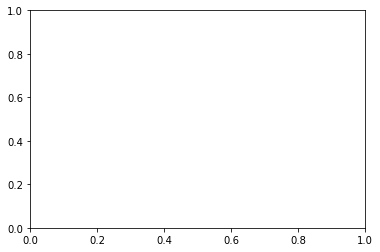

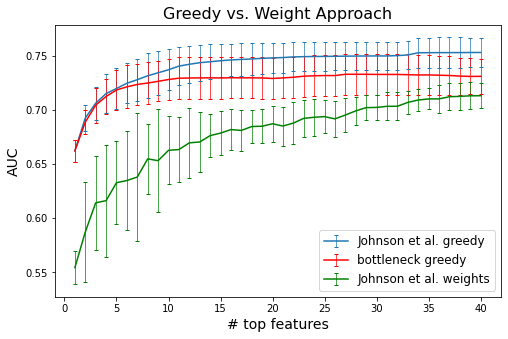

In [65]:
fig, ax = plt.subplots()
trans1 = Affine2D().translate(+0.2, 0.0) + ax.transData
trans2 = Affine2D().translate(-0.2, 0.0) + ax.transData
plt.figure(figsize=(8,5))
plt.errorbar(np.arange(1,41),np.mean(baseline_aucs_topk_all,axis=0),yerr=greedy_baseline_err,elinewidth = 0.7,capsize=2, label="Johnson et al. greedy",color="tab:blue")
plt.errorbar(np.arange(1,41),np.mean(bottleneck_aucs_topk_all,axis=0)[0],yerr=greedy_bottleneck_err,elinewidth = 0.7,capsize=2, label="bottleneck greedy",color="red")
plt.errorbar(np.arange(1,41),np.mean(baseline_aucs_topk_all_weights,axis=0),yerr=weights_err,elinewidth = 0.7,capsize=2, label="Johnson et al. weights",color="green")
# transform = trans1 <- goes as a property in plt.errorbar for second line
#transform = trans2 <- goes as a property in plt.errorbar for third line
plt.xlabel("# top features",fontsize=14)
plt.ylabel("AUC",fontsize=14)
plt.title("Greedy vs. Weight Approach",fontsize=16)
plt.legend(fontsize=12)

## Assign Concept Meanings

In [11]:
feature_weights_bottleneck = []
concept_weights = []
for r in rs:
    num_concepts = 4
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)

    file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,num_concepts))
    csvreader = csv.reader(file)
    header = next(csvreader)
    bottleneck_row = []
    for row in csvreader:
        ### *********CHANGE THIS******** ######
        if row[3]=="0.001" and row[4]=="0.01":
            bottleneck_row = np.array(row).astype(float)  
    # format hyperparameters for csv reader
    row=[int(el) if el >= 1 else el for el in bottleneck_row]
    row=[0 if el == 0 else el for el in bottleneck_row]

    set_seed(r)
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                                        changing_dim,
                                                                                        9,                     
                                                                                        num_concepts,
                                                                                        True,
                                                                                        init_cutoffs_to_zero, 
                                                                                        init_rand_lower_thresholds, 
                                                                                        init_rand_upper_thresholds,
                                                                                        cutoff_times_temperature=1.0,
                                                                                        cutoff_times_init_values=None,
                                                                                        opt_lr = row[1],
                                                                                        opt_weight_decay = row[2],
                                                                                        l1_lambda=row[3],
                                                                                        cos_sim_lambda = row[4]
                                                                                        )
    logregbottleneck.cuda()
    set_seed(r)
    logregbottleneck.fit(train_loader, val_loader, p_weight, 
                         save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r,int(row[0]),row[1],row[2],row[3],row[4]), 
                         epochs=10, 
                         save_every_n_epochs=10)

    for name, param in logregbottleneck.named_parameters():
        if "bottleneck.weight" in name:
            feature_weights_bottleneck.append(param.cpu().detach().numpy())
        if "linear.weight" in name:
            print("here")
            print(param[1])
            concept_weights.append(param[1].cpu().detach().numpy())
    

self top k

self.num_concepts
4
l1_lambda
0.001
cos_sim_lambda
0.01
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


here
tensor([ 2.1260,  0.6042, -0.5511, -1.1679], device='cuda:0',
       grad_fn=<SelectBackward>)
self top k

self.num_concepts
4
l1_lambda
0.001
cos_sim_lambda
0.01
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


here
tensor([-0.0173,  2.1801,  0.1675, -1.5132], device='cuda:0',
       grad_fn=<SelectBackward>)
self top k

self.num_concepts
4
l1_lambda
0.001
cos_sim_lambda
0.01
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r4_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


here
tensor([ 0.4801, -2.2725,  0.6128,  0.6831], device='cuda:0',
       grad_fn=<SelectBackward>)
self top k

self.num_concepts
4
l1_lambda
0.001
cos_sim_lambda
0.01
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r6_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


here
tensor([ 2.3033,  0.2673,  0.1682, -1.2075], device='cuda:0',
       grad_fn=<SelectBackward>)
self top k

self.num_concepts
4
l1_lambda
0.001
cos_sim_lambda
0.01
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r9_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


here
tensor([-1.8889,  0.3834, -0.1054,  2.1661], device='cuda:0',
       grad_fn=<SelectBackward>)
self top k

self.num_concepts
4
l1_lambda
0.001
cos_sim_lambda
0.01
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r10_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]

here
tensor([ 0.5272,  0.4198,  0.1619, -2.1018], device='cuda:0',
       grad_fn=<SelectBackward>)


In [35]:
for r in range(len(rs)):
    names = []
    funcs = []
    weights = []
    c=4
    bottleneck_top10_all = np.array(bottleneck_topk_all)[r][0][:14]
    bottleneck_top10_all_sorted=np.array(bottleneck_top10_all)[np.array(bottleneck_top10_all)[:, 1].argsort()]
    # concept_weights = logregbottleneck.model.linear.weight[1]
    for el in bottleneck_top10_all_sorted:
        name,func = getConcept(int(el[2]))
    #     weight = feature_weights_avg[c-1][4][int(el[1])][int(el[2])]
        weight = feature_weights_bottleneck[r][int(el[1])][int(el[2])]
        names.append(name)
        funcs.append(func)
        weights.append(round(weight,4))
    column_labels=["Concept Num","Concept Weight","Feat Name", "Feat Summary", "Feat Weight"]
    concepts = bottleneck_top10_all_sorted[:,1].astype(int)
    conc_weights = np.round(concept_weights[r][concepts],3)
    df = pd.DataFrame(list(zip(concepts,conc_weights,names,funcs,weights)), columns = column_labels)
#     df = df.style.apply(row_style, axis=1)
    display(df)

,Concept Num,Concept Weight,Feat Name,Feat Summary,Feat Weight
0,0,2.126,inr,hours above threshold,0.2281
1,0,2.126,spontaneousrr,last time measured,-0.3104
2,0,2.126,spontaneousrr,mean of indicators,-0.1474
3,0,2.126,inr,hours below threshold,0.2969
4,1,0.604,po2,hours above threshold,0.2284
5,1,0.604,GCS,slope std err,-0.0002
6,1,0.604,spo2,last time measured,-0.0224
7,1,0.604,hct,var of indicators,0.0002
8,1,0.604,glucose_ind,N/A,0.0002
9,1,0.604,po2,var of indicators,0.0002


,Concept Num,Concept Weight,Feat Name,Feat Summary,Feat Weight
0,0,-0.017,creatinine,var of indicators,0.0002
1,0,-0.017,bun,last time measured,0.0002
2,0,-0.017,magnesium,last time measured,0.0002
3,1,2.180,pco2,last time measured,0.1055
4,1,2.180,inr,hours above threshold,0.2755
5,1,2.180,spontaneousrr,last time measured,-0.1813
6,1,2.180,bilirubin_total,hours below threshold,0.0932
7,1,2.180,hct,mean of indicators,0.0869
8,1,2.180,dbp,mean of indicators,-0.0942
9,3,-1.513,spo2,last time measured,0.1929


,Concept Num,Concept Weight,Feat Name,Feat Summary,Feat Weight
0,0,0.480,map,var of indicators,-0.0000
1,0,0.480,lactate,slope std err,0.0001
2,0,0.480,lactate,ever measured,0.0000
3,0,0.480,magnesium_ind,N/A,-0.0001
4,0,0.480,urine,last time measured,0.0000
5,0,0.480,potassium,mean of indicators,0.0001
6,0,0.480,platelets,slope std err,-0.0000
7,0,0.480,platelets_ind,N/A,0.0000
8,0,0.480,map,# switches,0.0000
9,0,0.480,sodium,mean,0.0000


,Concept Num,Concept Weight,Feat Name,Feat Summary,Feat Weight
0,0,2.303,pco2,mean of indicators,0.1034
1,0,2.303,spontaneousrr,last time measured,-0.2144
2,0,2.303,alt,slope std err,0.1078
3,0,2.303,bilirubin_total,hours above threshold,0.0898
4,0,2.303,po2,mean of indicators,0.0887
5,1,0.267,potassium,last time measured,0.0000
6,1,0.267,bilirubin_total,first time measured,0.0001
7,1,0.267,fio2_ind,N/A,0.0001
8,1,0.267,urine,first time measured,-0.0001
9,1,0.267,fio2,hours below threshold,0.0000


,Concept Num,Concept Weight,Feat Name,Feat Summary,Feat Weight
0,0,-1.889,fio2,first time measured,-0.2971
1,0,-1.889,dbp,var of indicators,0.0841
2,0,-1.889,lactate,last time measured,-0.2666
3,0,-1.889,inr_ind,N/A,0.0903
4,1,0.383,inr,hours above threshold,0.0324
5,3,2.166,pco2,last time measured,0.4448
6,3,2.166,GCS,last time measured,-0.2155
7,3,2.166,hr_ind,N/A,-0.2664
8,3,2.166,ast,hours above threshold,0.0559
9,3,2.166,spo2,last time measured,-0.2338


,Concept Num,Concept Weight,Feat Name,Feat Summary,Feat Weight
0,0,0.527,urine,var of indicators,0.0002
1,0,0.527,map,last time measured,0.0263
2,0,0.527,bun_ind,N/A,-0.0002
3,1,0.420,po2,last time measured,-0.0005
4,1,0.420,lactate,ever measured,0.0001
5,2,0.162,pco2_ind,N/A,-0.0283
6,3,-2.102,po2,hours below threshold,-0.0744
7,3,-2.102,GCS,mean of indicators,0.0708
8,3,-2.102,inr,hours above threshold,-0.2857
9,3,-2.102,hr_ind,N/A,0.2521


## Try 8 concepts

In [18]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_topk_all = []
bottleneck_aucs_topk_all = []
rs = [1]
for r in rs:
    bottleneck_topk_run = []
    bottleneck_aucs_topk_run = []
    for c in range(8,9):
        file = open('./models/LOS-6-600/cos-sim/top-k/vasopressor_bottleneck_r{}_c{}_topkinds.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        bottleneck_topk_run.append(bottleneck_rows)
        bottleneck_aucs_topk_run.append(bottleneck_rows[:,0])
    bottleneck_topk_all.append(bottleneck_topk_run)
    bottleneck_aucs_topk_all.append(bottleneck_aucs_topk_run)
#     bottleneck_topk_all.append([bottleneck_topk_run[0][:20]])
#     bottleneck_aucs_topk_all.append([bottleneck_aucs_topk_run[0][:20]])

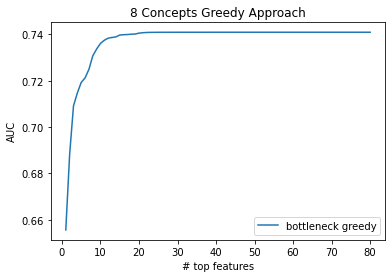

In [19]:
# fig, ax = plt.subplots()
# trans1 = Affine2D().translate(+0.2, 0.0) + ax.transData
# trans2 = Affine2D().translate(-0.2, 0.0) + ax.transData
plt.errorbar(np.arange(1,81),np.mean(bottleneck_aucs_topk_all,axis=0)[0],label="bottleneck greedy")
# plt.errorbar(np.arange(1,41),np.mean(baseline_aucs_topk_all,axis=0),yerr=greedy_baseline_err,elinewidth = 0.7,transform = trans1,label="baseline greedy")
# plt.errorbar(np.arange(1,41),np.mean(baseline_aucs_topk_all_weights,axis=0),yerr=weights_err,elinewidth = 0.7,transform = trans2, label="baseline weights")
plt.xlabel("# top features")
plt.ylabel("AUC")
plt.title("8 Concepts Greedy Approach")
plt.legend()

In [20]:
rs = [1]
feature_weights_bottleneck = []
concept_weights = []
for r in rs:
    num_concepts = 8
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)

    file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,num_concepts))
    csvreader = csv.reader(file)
    header = next(csvreader)
    bottleneck_row = []
    for row in csvreader:
        ### *********CHANGE THIS******** ######
        if row[3]=="0.001" and row[4]=="0.01":
            bottleneck_row = np.array(row).astype(float)  
    # format hyperparameters for csv reader
    row=[int(el) if el >= 1 else el for el in bottleneck_row]
    row=[0 if el == 0 else el for el in bottleneck_row]

    set_seed(r)
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                                        changing_dim,
                                                                                        9,                     
                                                                                        num_concepts,
                                                                                        True,
                                                                                        init_cutoffs_to_zero, 
                                                                                        init_rand_lower_thresholds, 
                                                                                        init_rand_upper_thresholds,
                                                                                        cutoff_times_temperature=1.0,
                                                                                        cutoff_times_init_values=None,
                                                                                        opt_lr = row[1],
                                                                                        opt_weight_decay = row[2],
                                                                                        l1_lambda=row[3],
                                                                                        cos_sim_lambda = row[4]
                                                                                        )
    logregbottleneck.cuda()
    set_seed(r)
    logregbottleneck.fit(train_loader, val_loader, p_weight, 
                         save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r,int(row[0]),row[1],row[2],row[3],row[4]), 
                         epochs=10, 
                         save_every_n_epochs=10)

    for name, param in logregbottleneck.named_parameters():
        if "bottleneck.weight" in name:
            feature_weights_bottleneck.append(param.cpu().detach().numpy())
        if "linear.weight" in name:
            print("here")
            print(param[1])
            concept_weights.append(param[1].cpu().detach().numpy())
    

self top k

self.num_concepts
8
l1_lambda
0.001
cos_sim_lambda
0.01
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]

here
tensor([ 0.2501,  1.8945,  0.3907, -0.5858,  0.2711,  0.2085,  0.0151, -1.6856],
       device='cuda:0', grad_fn=<SelectBackward>)


In [21]:
for r in range(len(rs)):
    names = []
    funcs = []
    weights = []
    c=8
    bottleneck_top10_all = np.array(bottleneck_topk_all)[r][0][:15]
    bottleneck_top10_all_sorted=np.array(bottleneck_top10_all)[np.array(bottleneck_top10_all)[:, 1].argsort()]
    # concept_weights = logregbottleneck.model.linear.weight[1]
    for el in bottleneck_top10_all_sorted:
        name,func = getConcept(int(el[2]))
    #     weight = feature_weights_avg[c-1][4][int(el[1])][int(el[2])]
        weight = feature_weights_bottleneck[r][int(el[1])][int(el[2])]
        names.append(name)
        funcs.append(func)
        weights.append(round(weight,3))
    column_labels=["Conc Num","Conc Weight","Feat Name", "Feat Summary", "Feat Weight"]
    concepts = bottleneck_top10_all_sorted[:,1].astype(int)
    conc_weights = np.round(concept_weights[r][concepts],3)
    df = pd.DataFrame(list(zip(concepts,conc_weights,names,funcs,weights)), columns = column_labels)
    display(df)

,Conc Num,Conc Weight,Feat Name,Feat Summary,Feat Weight
0,1,1.894,pco2,ever measured,0.471
1,1,1.894,inr,hours below threshold,0.224
2,1,1.894,spo2,last time measured,-0.133
3,1,1.894,hr,last time measured,-0.328
4,2,0.391,lactate,last time measured,0.047
5,3,-0.586,spo2,mean of indicators,0.343
6,3,-0.586,pco2,hours above threshold,-0.174
7,7,-1.686,temp,first time measured,0.247
8,7,-1.686,spo2_ind,N/A,0.105
9,7,-1.686,bilirubin_total,hours above threshold,-0.105


## Fine-tune models

In [64]:
# feature_weights_bottleneck = []
# concept_weights = []
for r in range(1,2):
    num_concepts = 4
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)

    file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,num_concepts))
    csvreader = csv.reader(file)
    header = next(csvreader)
    bottleneck_row = []
    for row in csvreader:
        ### *********CHANGE THIS******** ######
        if row[3]=="0.001" and row[4]=="0.01":
            bottleneck_row = np.array(row).astype(float)  
    # format hyperparameters for csv reader
    row=[int(el) if el >= 1 else el for el in bottleneck_row]
    row=[0 if el == 0 else el for el in bottleneck_row]

    set_seed(r)
    logregbottleneck = LogisticRegressionWithSummariesAndBottleneck_Wrapper(input_dim, 
                                                                                        changing_dim,
                                                                                        9,                     
                                                                                        num_concepts,
                                                                                        True,
                                                                                        init_cutoffs_to_zero, 
                                                                                        init_rand_lower_thresholds, 
                                                                                        init_rand_upper_thresholds,
                                                                                        cutoff_times_temperature=1.0,
                                                                                        cutoff_times_init_values=None,
                                                                                        opt_lr = row[1],
                                                                                        opt_weight_decay = row[2],
                                                                                        l1_lambda=row[3],
                                                                                        cos_sim_lambda = row[4],
#                                                                                         top_k = './models/LOS-6-600/cos-sim/top-k/topkindsr{}c4.csv'.format(r)
                                                                                        )
    logregbottleneck.cuda()
    set_seed(r)
    logregbottleneck.fit(train_loader, val_loader, p_weight, 
                         save_model_path = "./models/LOS-6-600/cos-sim/top-k/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}_finetune.pt".format(r,int(row[0]),row[1],row[2],row[3],row[4]), 
                         epochs=10, 
                         save_every_n_epochs=10)
    

self top k

self.num_concepts
4
self.bottleneck.weight after 
Parameter containing:
tensor([[ 0.0257, -0.0220, -0.0097,  ...,  0.0288, -0.0254,  0.0350],
        [ 0.0003, -0.0400, -0.0105,  ...,  0.0460,  0.0313,  0.0496],
        [-0.0225, -0.0062,  0.0103,  ...,  0.0159,  0.0115, -0.0469],
        [-0.0184,  0.0053, -0.0347,  ..., -0.0269,  0.0439,  0.0465]],
       requires_grad=True)
l1_lambda
0.001
cos_sim_lambda
0.01
Loaded model from ./models/LOS-6-600/cos-sim/top-k/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.01_finetune.pt


0it [00:00, ?it/s]

self.bottleneck.weight
Parameter containing:
tensor([[    -0.0000,      0.0000,     -0.0000,  ...,      0.2969,
              0.0000,     -0.0000],
        [    -0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              0.0000,      0.0000],
        [     0.0000,      0.0000,      0.0000,  ...,     -0.0000,
              0.0000,     -0.0000],
        [    -0.0000,      0.0000,      0.0000,  ...,     -0.0002,
              0.0000,      0.0000]], device='cuda:0', requires_grad=True)


# Plot feature weights bottleneck vs. baseline

In [41]:
feature_weights = []
concept_weights = []
for r in range(1,11):
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)
    feature_weights_run = []
    for c in range(4,5):
        file = open('./models/LOS-6-600/cos-sim/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
#         for row in bottleneck_reg_all[r-1][c-1]:
        for row in bottleneck_rows:
            print(row)
            if row[3]==0.001 and row[4]==0.01:
                # format hyperparameters for csv reader
                row=[int(el) if el >= 1 else el for el in row]
                row=[0 if el == 0 else el for el in row]

                # initialize model
                logregbottleneck = initializeModel(c)
#                 print("./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]))
                logregbottleneck.fit(train_loader, val_loader, p_weight, 
                     save_model_path = "./models/LOS-6-600/cos-sim/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}_cossim_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3],row[4]), 
                     epochs=1000, 
                     save_every_n_epochs=10)

                for name, param in logregbottleneck.named_parameters():
                    if "bottleneck.weight" in name:
                        bottleneck_weights = param
                feature_weights_run.append(bottleneck_weights.cpu().detach().numpy())
    feature_weights.append(feature_weights_run)

[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e+01 6.84248759e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 0.00000000e+00 7.22502989e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e+00 7.10384255e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-01 7.25255077e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-03 7.23613371e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-02 7.24628281e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-04 7.22596385e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-05 7.22509215e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e+01 7.20787604e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e+00 7.21503645e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 0.00000000e+00 7.22792518e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-01 7.22234214e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-03 7.22846481e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.22547612e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r2_c4_optlr_0.001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-05 7.22873462e-01]
[4.00000000e+00 1.00000000e-03 1.00000000e-03 1.00000000e-03
 1.00000000e-04 7.22848556e-01]
[4.0000000e+00 1.0000000e-04 1.0000000e-03 1.0000000e-03 1.0000000e+01
 7.2388007e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e+00 7.39825992e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 0.00000000e+00 7.44842429e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-01 7.42779401e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.44238464e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r3_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-03 7.44157521e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-04 7.44792618e-01]
[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-05 7.44825826e-01]
[4.00000000e+00 1.00000000e-04 0.00000000e+00 1.00000000e-03
 1.00000000e-02 7.39402594e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r4_c4_optlr_0.0001_optwd_0_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-02 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.16543245e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r5_c4_optlr_0.01_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.07934149e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r6_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-02 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.42804307e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r7_c4_optlr_0.01_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-02 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.07164146e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r8_c4_optlr_0.01_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.0000000e+00 1.0000000e-04 1.0000000e-03 1.0000000e-03 1.0000000e-02
 7.0215601e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r9_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4.00000000e+00 1.00000000e-04 1.00000000e-03 1.00000000e-03
 1.00000000e-02 7.28186694e-01]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/cos-sim/bottleneck_r10_c4_optlr_0.0001_optwd_0.001_l1_lambda_0.001_cossim_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


r
10


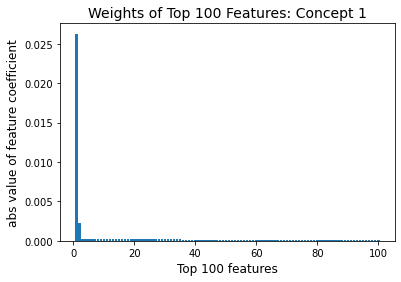

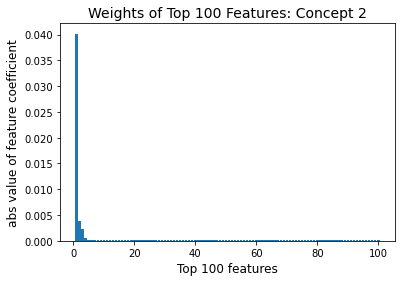

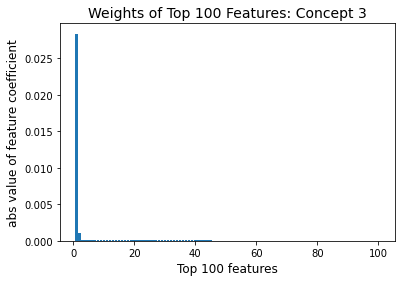

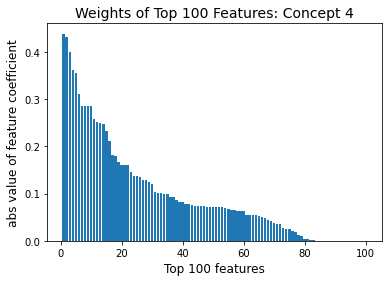

In [44]:
# rs = [1,3,6,9,10]
rs=[10]
for r in rs:
    print("r")
    print(r)
    for c in range(4):
        inds = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))[:100]
        plt.bar(np.arange(1,101),np.abs(feature_weights[r-1][0][c])[inds])
        plt.xlabel("Top 100 features",fontsize=12)
        plt.ylabel("abs value of feature coefficient",fontsize=12)
        plt.title("Weights of Top 100 Features: Concept " + str(c+1), fontsize=14)
        plt.show()

In [97]:
# rs = [1,6,10]
baseline_top1_all = []
# for r in rs:
for r in range(1,11):
    set_seed(r)
    file = open('./models/LOS-6-600/baseline/vasopressor_baseline_gridsearch_r{}.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
        baseline_rows.append(np.array(row).astype(float))
    baseline_rows = np.array(baseline_rows)
    sorted_baseline_rows = baseline_rows[np.argsort(baseline_rows[:,4])]
    baseline_top1=sorted_baseline_rows[-1:]
    baseline_top1_auc=sorted_baseline_rows[-1:][:,4]
    baseline_top1_all.append(baseline_top1)

In [98]:
feature_weights = []
for r in range(1,11):
    row = baseline_top1_all[r-1][0]
    row=[int(el) if el >= 1 else el for el in row]
    row=[0 if el == 0 else el for el in row]
    logreg = initializeModelNoBottleneck()
    train_loader, val_loader, X_test, y_test, p_weight = initializeData(r)

    logreg = LogisticRegressionWithSummaries_Wrapper(input_dim, 
                                                    changing_dim, 
                                                    9,        
                                                    True,
                                                    init_cutoffs_randomly, 
                                                    init_rand_lower_thresholds, 
                                                    init_rand_upper_thresholds,
                                                    cutoff_times_temperature=0.1,
                                                    alpha = row[0],
                                                    tau = row[1],
                                                    opt_lr = row[2],
                                                    opt_weight_decay = row[3])


    logreg.fit(train_loader, val_loader, p_weight, 
         save_model_path = "./models/LOS-6-600/baseline/baseline_r{}_alpha_{}_tau_{}_optlr_{}_optwd_{}.pt".format(r, row[0], row[1], row[2], row[3]), 
         epochs=1000, 
         save_every_n_epochs=10)

    for name, param in logreg.named_parameters():
        if "linear.weight" in name:
            feature_weights.append(param[1].cpu().detach().numpy())

in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r1_alpha_0.01_tau_1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r2_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r3_alpha_0.0001_tau_0.1_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r4_alpha_1e-05_tau_40_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r5_alpha_0.01_tau_1_optlr_0.0001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r6_alpha_0.01_tau_1_optlr_0.001_optwd_0.0001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r7_alpha_0.01_tau_20_optlr_0.01_optwd_0.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r8_alpha_0_tau_20_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r9_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


in init
TEST1
in init
TEST1
Loaded model from ./models/LOS-6-600/baseline/baseline_r10_alpha_1e-06_tau_60_optlr_0.0001_optwd_0.001.pt


0it [00:00, ?it/s]


In [101]:
baseline_topk_all = []
baseline_aucs_topk_all = []
rs = [10]
for r in rs:
    file = open('./models/LOS-6-600/baseline/vasopressor_baseline_r{}_topkinds.csv'.format(r))
    csvreader = csv.reader(file)
    header = []
    header = next(csvreader)
    baseline_rows = []
    for row in csvreader:
            baseline_rows.append(np.array(row).astype(float))
    baseline_topk_all.append(np.array(baseline_rows))
    baseline_aucs_topk_all.append(np.array(baseline_rows)[:,0])

In [102]:
baseline_aucs_topk_all

[array([0.66002893, 0.69486069, 0.70932265, 0.71322766, 0.71611881,
        0.72059147, 0.72216157, 0.7263748 , 0.73330898, 0.73850599,
        0.7423093 , 0.74448026, 0.74544328, 0.74617178, 0.74681621,
        0.7474731 , 0.74784565, 0.74810301, 0.74887716, 0.7490899 ,
        0.74915735, 0.74951953, 0.74996472, 0.75007264, 0.75009547,
        0.75011934, 0.75000934, 0.74981009, 0.74966689, 0.74955066,
        0.74932858, 0.75073783, 0.75367983, 0.76374487, 0.76411327,
        0.7642378 , 0.76432808, 0.76434054, 0.7642928 , 0.76428761])]

In [79]:
best_feat_weights = []
best_feat_concs = []
    
for r in range(len(rs)):
    names = []
    funcs = []
    weights = []
    c=4
    baseline_top10_all = np.array(baseline_topk_all)[r][0][:14]
    baseline_top10_all_sorted=np.array(baseline_top10_all)[np.array(bottleneck_top10_all)[:, 1].argsort()]
    # concept_weights = logregbottleneck.model.linear.weight[1]
    for el in bottleneck_top10_all_sorted:
        name,func = getConcept(int(el[2]))
    #     weight = feature_weights_avg[c-1][4][int(el[1])][int(el[2])]
        weight = feature_weights_bottleneck[r][int(el[1])][int(el[2])]
        best_feat_weights.append(weight)
        best_feat_concs.append(int(el[1]))

In [80]:
best_feat_concs

[0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 3, 3, 3]

In [81]:
best_feat_inds = []
best_feat_per_conc_x = [[],[],[],[]]
best_feat_per_conc_y = [[],[],[],[]]
for i in range(14):
    inds = np.argsort(-np.abs(np.array(feature_weights_bottleneck)[r-1][best_feat_concs[i]]))[:100]
    top100 = feature_weights_bottleneck[r-1][best_feat_concs[i]][inds]
    ind = np.where(top100==best_feat_weights[i])[0]
    if np.array_equal(ind,np.array([])):
        ind = np.array([100])
    best_feat_inds.append(ind[0])
    best_feat_per_conc_x[best_feat_concs[i]].append(ind[0])
    best_feat_per_conc_y[best_feat_concs[i]].append(best_feat_weights[i])
best_feat_inds
print(best_feat_per_conc_x)
best_feat_per_conc_y

[[47, 0, 11], [3, 100], [0], [44, 50, 8, 11, 49, 26, 30, 46]]


[[0.00015103967, 0.026280269, -0.00020109689],
 [-0.0004808791, 6.687577e-05],
 [-0.028344799],
 [-0.07442154,
  0.0708194,
  -0.28571767,
  0.25208187,
  0.0715895,
  -0.12836534,
  0.10278183,
  0.073938005]]

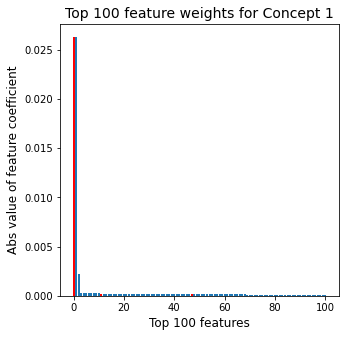

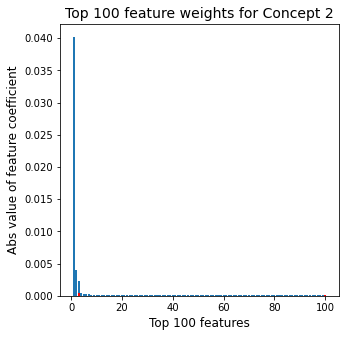

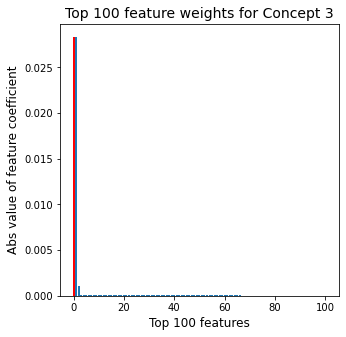

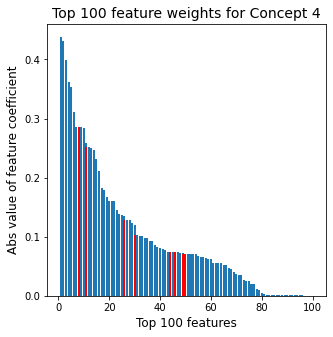

In [96]:
# POST OPTIMIZATION
# rs = [1,3,6,9,10]
best_inds = bottleneck_topk_all[:14][0][0]
best_inds_x = bottleneck_topk_all[:14][0][0][:,0]
rs=[10]
for r in rs:
    for c in range(4):
        fig = plt.figure(figsize=[5,5])
        ax = fig.add_subplot(111)
        inds = np.argsort(-np.abs(np.array(feature_weights)[r-1][0][c]))[:100]
        ax.bar(np.arange(1,101),np.abs(feature_weights[r-1][0][c])[inds])
        ax.bar(best_feat_per_conc_x[c],np.abs(best_feat_per_conc_y[c]),color='r')
        ax.set_xlabel("Top 100 features",fontsize=12)
        ax.set_title("Top 100 feature weights for Concept "+str(c+1),fontsize=14)
        ax.set_ylabel("Abs value of feature coefficient",fontsize=12)
        plt.show()

r
10


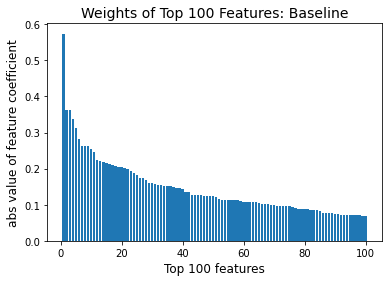

In [46]:
# rs = [1,3,6,9,10]
rs=[10]
for r in rs:
    print("r")
    print(r)
    inds = np.argsort(-np.abs(np.array(feature_weights)[r-1]))[:100]
    plt.bar(np.arange(1,101),np.abs(feature_weights[r-1])[inds])
    plt.xlabel("Top 100 features", fontsize=12)
    plt.ylabel("abs value of feature coefficient", fontsize=12)
    plt.title("Weights of Top 100 Features: Baseline", fontsize=14)
    plt.show()

In [35]:
np.array(feature_weights).shape

(10, 402)

# Completeness Score

In [22]:
# BOTTLENECK: get AUCs from hyperparameter scan

bottleneck_reg_all = []
bottleneck_aucs_reg_all = []
for r in range(3,4):
    bottleneck_reg_run = []
    bottleneck_aucs_reg_run = []
    for c in range(1,9):
        file = open('./models/LOS-6-600/l1-reg/vasopressor_bottleneck_r{}_c{}_gridsearch.csv'.format(r,c))
        csvreader = csv.reader(file)
        header = []
        header = next(csvreader)
        bottleneck_rows = []
        for row in csvreader:
                bottleneck_rows.append(np.array(row).astype(float))
        bottleneck_rows = np.array(bottleneck_rows)
        sorted_bottleneck_rows = bottleneck_rows[np.argsort(bottleneck_rows[:,3])]
        bottleneck_reg_run.append(sorted_bottleneck_rows[1:])
        bottleneck_aucs_reg_run.append(sorted_bottleneck_rows[1:,4])
    bottleneck_reg_all.append(bottleneck_reg_run)
    bottleneck_aucs_reg_all.append(bottleneck_aucs_reg_run)

In [109]:
indices = [3, 3, 3, 2, 2, 2, 2, 2]
for r in range(1,2):
    for c in range(1,9):
        row = bottleneck_reg_all[r-1][c-1][indices[c-1]]
        # format hyperparameters for csv reader
        row=[int(el) if el >= 1 else el for el in row]
        row=[0 if el == 0 else el for el in row]
        print(row)

        # initialize model
        logregbottleneck = initializeModel(c)

        logregbottleneck.fit(train_loader, val_loader, p_weight, 
             save_model_path = "./models/LOS-6-600/l1-reg/bottleneck_r{}_c{}_optlr_{}_optwd_{}_l1_lambda_{}.pt".format(r, row[0],row[1],row[2],row[3]), 
             epochs=1000, 
             save_every_n_epochs=10)
        for name, param in logregbottleneck.named_parameters():
            if "bottleneck.weight" in name:
                torch.set_printoptions(precision=10)
                np.savetxt("./models/LOS-6-600/completeness/r1_c{}.out".format(c), param.detach().cpu().numpy(), delimiter=',')

[1, 0.001, 0.001, 0.01, 0.4563619722051571]
self top k

self.num_concepts
1
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c1_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[2, 0.001, 0.001, 0.01, 0.4230951234496156]
self top k

self.num_concepts
2
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c2_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[3, 0.001, 0.001, 0.01, 0.43991378451525065]
self top k

self.num_concepts
3
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c3_optlr_0.001_optwd_0.001_l1_lambda_0.01.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[4, 0.0001, 0, 0.001, 0.722502988692779]
self top k

self.num_concepts
4
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c4_optlr_0.0001_optwd_0_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[5, 0.0001, 0.001, 0.001, 0.7199335430952896]
self top k

self.num_concepts
5
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c5_optlr_0.0001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[6, 0.0001, 0.0001, 0.001, 0.7212846812891227]
self top k

self.num_concepts
6
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c6_optlr_0.0001_optwd_0.0001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[7, 0.001, 0.001, 0.001, 0.7273513125342455]
self top k

self.num_concepts
7
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c7_optlr_0.001_optwd_0.001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]


[8, 0.0001, 0.0001, 0.001, 0.7222373271124247]
self top k

self.num_concepts
8
l1_lambda
0.0
cos_sim_lambda
0.0
Loaded model from ./models/LOS-6-600/l1-reg/bottleneck_r1_c8_optlr_0.0001_optwd_0.0001_l1_lambda_0.001.pt
loaded model curr epoch
999


0it [00:00, ?it/s]
